In [1]:
import pandas as pd
import numpy as np
import datetime
import os
os.chdir('C:\\Users\\bella\\OneDrive\\Desktop\\projects\\QiShi\\code')
import logging
from dataLoader.data_loader import loadData

In [2]:
startDate = datetime.date(2018,1,10)
endDate = datetime.date(2020,12,31)

In [3]:
priceData = loadData(startDate, endDate, 'eod_priceAdj')

In [4]:
priceData = priceData.sort_values(by = ['date', 'ticker'])

In [5]:
priceData

date  ticker       high        low       open      close  \
index                                                                    
6       2018-01-10  000001   134900.0   129200.0   130399.0   134700.0   
44      2018-01-10  000002   366700.0   355000.0   356000.0   356700.0   
82      2018-01-10  000004   230300.0   223500.0   230300.0   224000.0   
120     2018-01-10  000005    44000.0    42900.0    43900.0    43200.0   
158     2018-01-10  000008    85399.0    83400.0    84900.0    84900.0   
...            ...     ...        ...        ...        ...        ...   
2432887 2020-12-31  688333  1523300.0  1487000.0  1489000.0  1519800.0   
2432901 2020-12-31  688366   914000.0   871700.0   874000.0   901500.0   
2432915 2020-12-31  688368  1800000.0  1563000.0  1594199.0  1720900.0   
2432929 2020-12-31  688369   774500.0   759400.0   773500.0   768000.0   
2432943 2020-12-31  688388   915000.0   861000.0   869000.0   881400.0   

         daily_return_adj  adj_factor  
index                                  
6                0.029817         1.0  
44              -0.004743         1.0  
82              -0.026933         1.0  
120             -0.020408         1.0  
158              0.000000         1.0  
...                   ...         ...  
2432887          0.022746         1.0  
2432901          0.037161         1.0  
2432915          0.101165         1.0  
2432929          0.000130         1.0  
2432943          0.014269         1.0  

[2414770 rows x 8 columns]

## Momentum 001: N day return.
#### We define the N day return at T0 to be return from T-(N+1) to T-1, following delay 1 scheme

In [6]:
priceData['prev_1_close'] = priceData.groupby(['ticker'])['close'].shift(1)
priceData['prev_6_close'] = priceData.groupby(['ticker'])['close'].shift(6)
priceData['prev_11_close'] = priceData.groupby(['ticker'])['close'].shift(11)
priceData['prev_21_close'] = priceData.groupby(['ticker'])['close'].shift(21)

In [7]:
priceData[['prev_6_close', 'prev_11_close', 'prev_21_close']] = priceData.groupby('ticker')[['prev_6_close', 'prev_11_close', 'prev_21_close']].ffill().bfill()

In [8]:
priceData['ret_5d'] = (priceData['prev_6_close']  - priceData['prev_1_close'])/priceData['prev_1_close']
priceData['ret_10d'] = (priceData['prev_11_close']  - priceData['prev_1_close'])/priceData['prev_1_close']
priceData['ret_20d'] = (priceData['prev_21_close']  - priceData['prev_1_close'])/priceData['prev_1_close']

In [44]:
import backtester.backtest as bt
startDate = datetime.date(2018,2,1)
endDate = datetime.date(2020,12,31)

In [37]:
params = {
    'holdingPeriod':3,
    'signal_univ':'zz9999', #'zz9999'
    'bmk':'000905',
    'neutralize_method': None,
    'weight_method': 'zscore', #'equal'
    'decile_number': 10,
    'top_decile':0,
    'bottom_decile':9   
    
}

In [113]:
backtester_hold1 = bt.BackTest(startDate, endDate, 1)

In [45]:
backtester_hold3 = bt.BackTest(startDate, endDate, 3)

In [46]:
backtester_hold5 = bt.BackTest(startDate, endDate, 5)

In [47]:
backtester_hold10 = bt.BackTest(startDate, endDate, 10)

In [26]:
score = priceData[['date', 'ticker','ret_20d']]

In [27]:
factor_name = 'past_20d_return'

### observation:
#### past returns don't have a significant result during backtest, returns largely from short side

C:\Users\bella\OneDrive\Desktop\projects\QiShi\code\backtester\backtest.py:389: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=2.0)


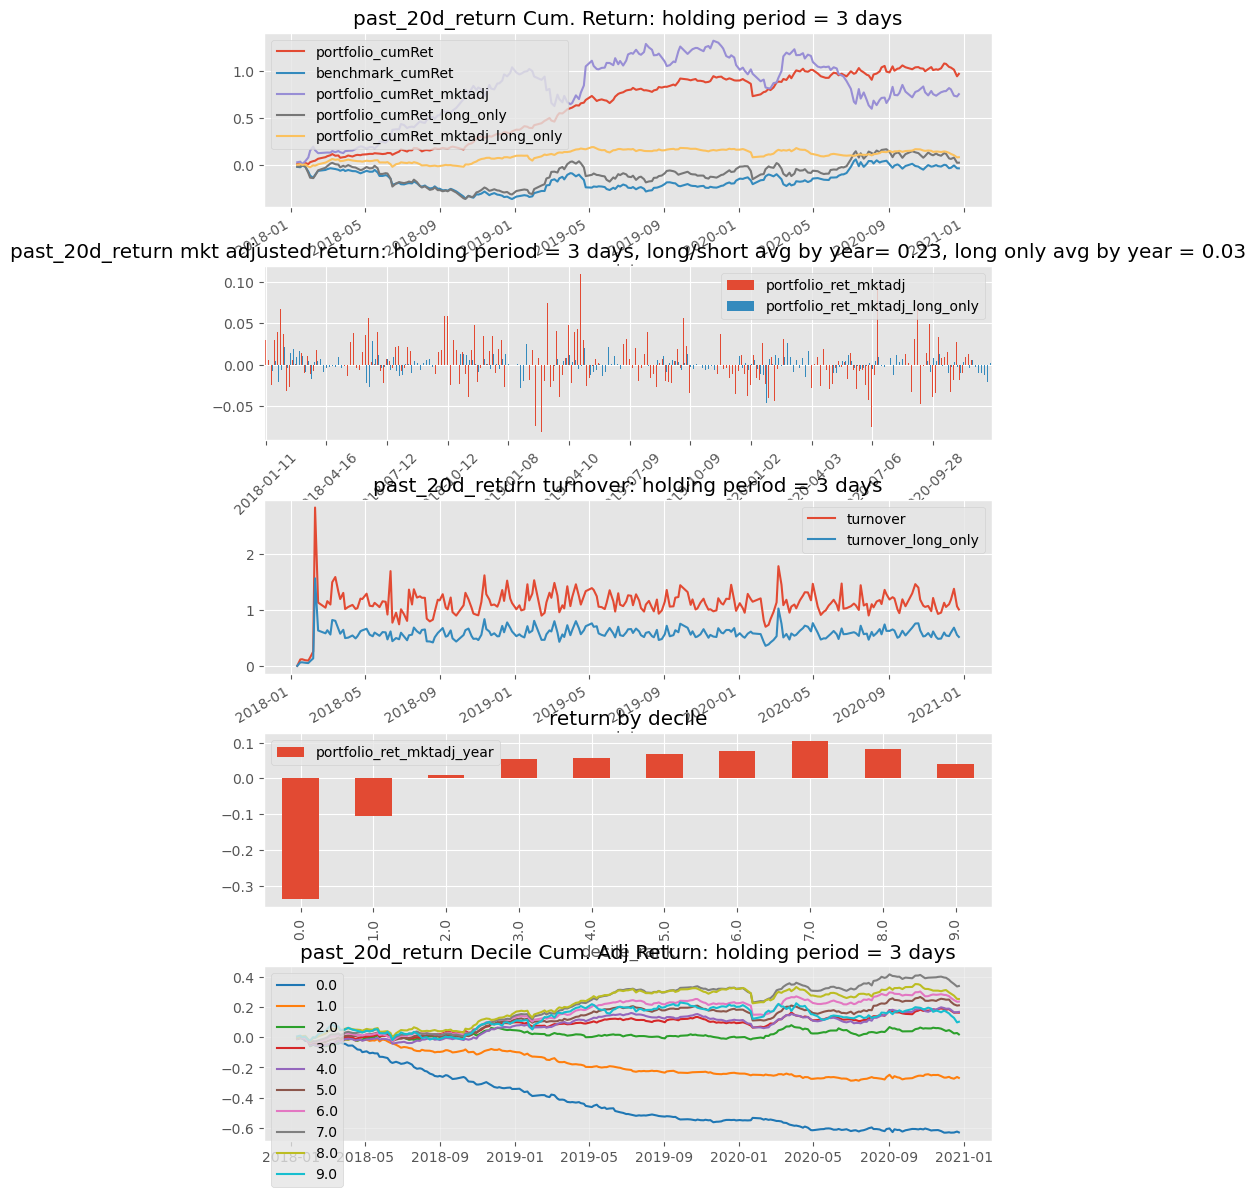

In [38]:
portfolioOutput, portfolioStats, portfolioOutput_long, portfolioStats_long, decileOutput, decileStats = bt.runBacktest(backtester_hold3, params, score, factor_name )

In [67]:
portfolioStats_long

portfolioIR  portfolioIC  portfolioIC_sig_ratio  turnover  maxDrawDown  \
0     0.352144    -0.004303               0.879167  0.580993     0.091317   

    corrBmk    decay1    decay3    decay5  decay10   decay20  
0  0.952135 -0.004303 -0.012795 -0.010317   -0.019 -0.019883

In [39]:
portfolioStats

portfolioIR  portfolioIC  portfolioIC_sig_ratio  turnover  maxDrawDown  \
0      0.89527     0.050637               0.866667  1.124124     0.310893   

    corrBmk    decay1    decay3    decay5   decay10   decay20  
0  0.138859  0.050637  0.029044  0.015041 -0.007189 -0.009248

## Momentum 002: percentage price oscillator (PPO)
#### price MA cross over, (M day MA - N day MA) / N day MA, M < N

In [35]:
for window in [3, 5, 10, 15, 20, 30]:
    MA_col = str(window)  + 'dMA' 
    EMA_col = str(window)  + 'dEMA' 
    priceData[MA_col] = priceData.groupby([ 'ticker'])['close'].transform(lambda x: x.rolling(window, int(np.ceil(window/2))).mean())   
    priceData[EMA_col] =  priceData.groupby([ 'ticker'])['close'].transform(lambda x: x.ewm(span = window, min_periods = int(np.ceil(window/2)) ).mean())

In [ ]:
for pair in [(3,10), (3, 15), (3, 5), (5,10), (5, 15), (5, 20), (10, 20), (10, 30)]:
    m = pair[0]
    n = pair[1]
    m_MA_col, n_MA_col = str(m)  + 'dMA' , str(n)  + 'dMA' 
    m_EMA_col, n_EMA_col = str(m)  + 'dEMA' , str(n)  + 'dEMA' 
    cross_over_col_ma = 'MA_' + str(m) + '_over' + str(n)
    cross_over_col_ema = 'EMA_' + str(m) + '_over' + str(n)
    priceData[cross_over_col_ma] = (priceData[m_MA_col] - priceData[n_MA_col])/priceData[n_MA_col]
    priceData[cross_over_col_ema] = (priceData[m_EMA_col] - priceData[n_EMA_col])/priceData[n_EMA_col]

In [37]:
priceData.columns

Index(['date', 'ticker', 'high', 'low', 'open', 'close', 'daily_return_adj',
       'adj_factor', '5dMA', '5dEMA', '10dMA', '10dEMA', '15dMA', '15dEMA',
       '20dMA', '20dEMA', '30dMA', '30dEMA', 'MA_5_over10', 'EMA_5_over10',
       'MA_5_over15', 'EMA_5_over15', 'MA_5_over20', 'EMA_5_over20',
       'MA_10_over20', 'EMA_10_over20', 'MA_10_over30', 'EMA_10_over30'],
      dtype='object')

In [9]:
from utils.helper import Filter

In [64]:
factorCols = Filter(priceData.columns.to_list(), ['over'])

In [65]:
factorCols

['MA_5_over10',
 'EMA_5_over10',
 'MA_5_over15',
 'EMA_5_over15',
 'MA_5_over20',
 'EMA_5_over20',
 'MA_10_over20',
 'EMA_10_over20',
 'MA_10_over30',
 'EMA_10_over30',
 'MA_3_over10',
 'EMA_3_over10',
 'MA_3_over15',
 'EMA_3_over15',
 'MA_3_over5',
 'EMA_3_over5']

In [66]:
params = {
    'holdingPeriod':10,
    'signal_univ':'zz9999', #'zz9999'
    'bmk':'000905',
    'neutralize_method': None,
    'weight_method': 'zscore', #'equal'
    'decile_number': 10,
    'top_decile':0,
    'bottom_decile':9   
    
}

In [18]:
from backtester.backtest_multiProcess import backtest_multi_process

In [ ]:
q = backtest_multi_process(priceData, factorCols, backtester_hold5, params, processes = 5)

sub list number: 5
splitted list ready
sub list length: 2
sub list length: 2
sub list length: 2
sub list length: 2
sub list length: 2


### observation: 
#### this type of signal has a opposite sign --> factor score small, better return, which indicates a long term reversal
#### MA and EMA of 10 day over 20 or 30 day avg returns have significant pattern

In [69]:
factorCols = Filter(priceData.columns.to_list(), ['10_over'])

In [71]:
factorCols

['MA_10_over20', 'EMA_10_over20', 'MA_10_over30', 'EMA_10_over30']

C:\Users\bella\OneDrive\Desktop\projects\QiShi\code\backtester\backtest.py:389: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=2.0)
C:\Users\bella\OneDrive\Desktop\projects\QiShi\code\backtester\backtest.py:389: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=2.0)
C:\Users\bella\OneDrive\Desktop\projects\QiShi\code\backtester\backtest.py:389: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=2.0)
C:\Users\bella\OneDrive\Desktop\projects\QiShi\code\backtester\backtest.py:389: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=2.0)


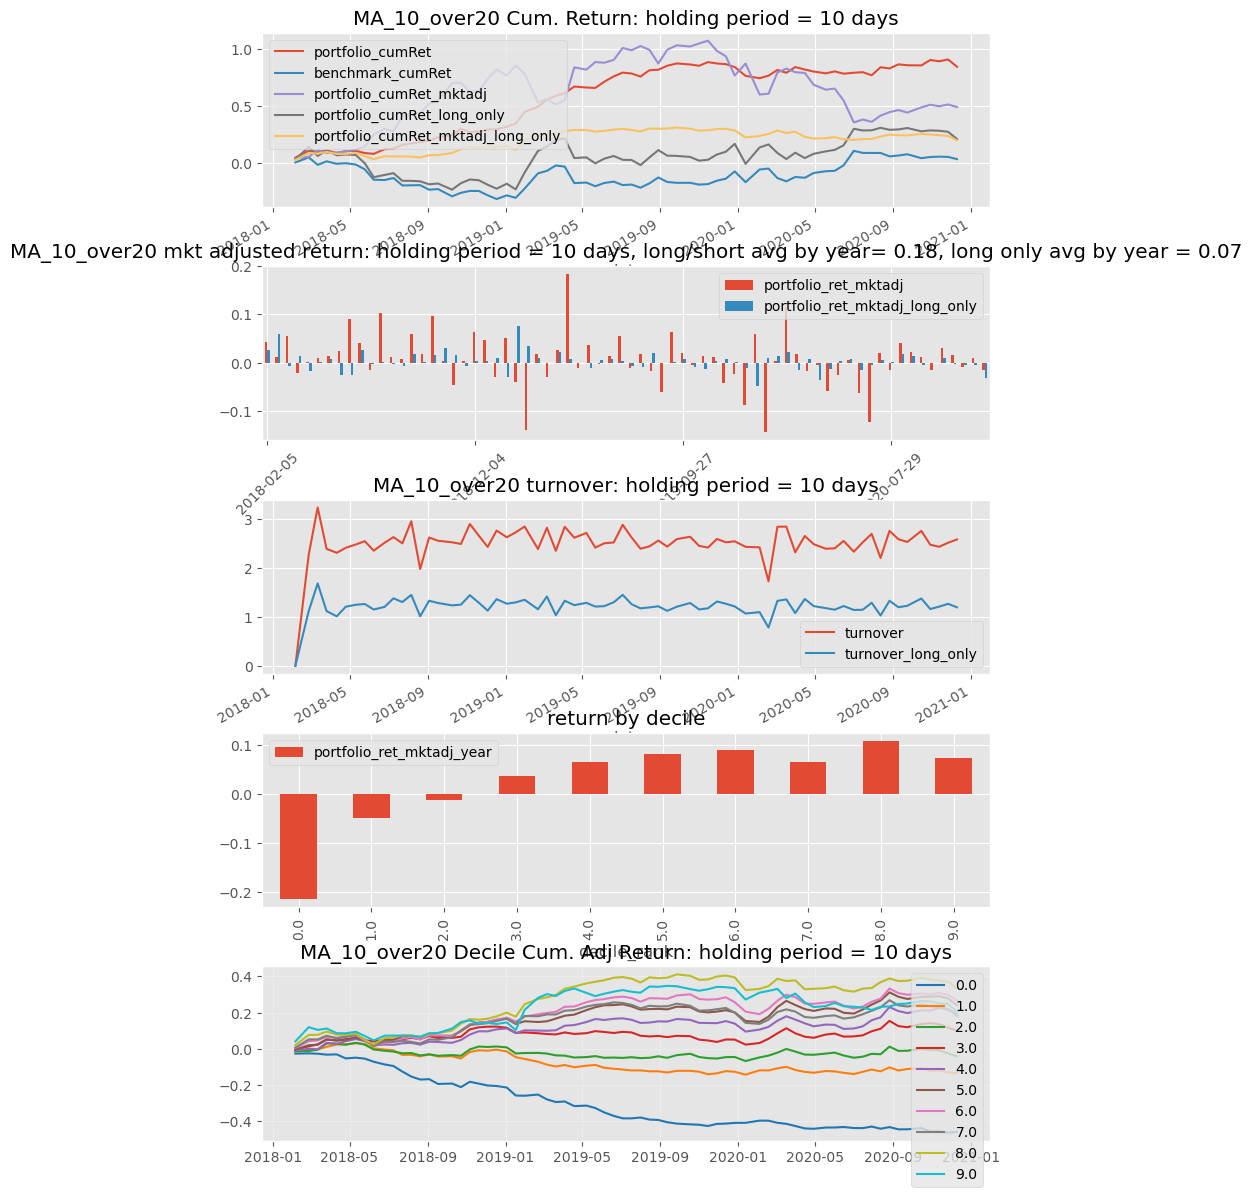

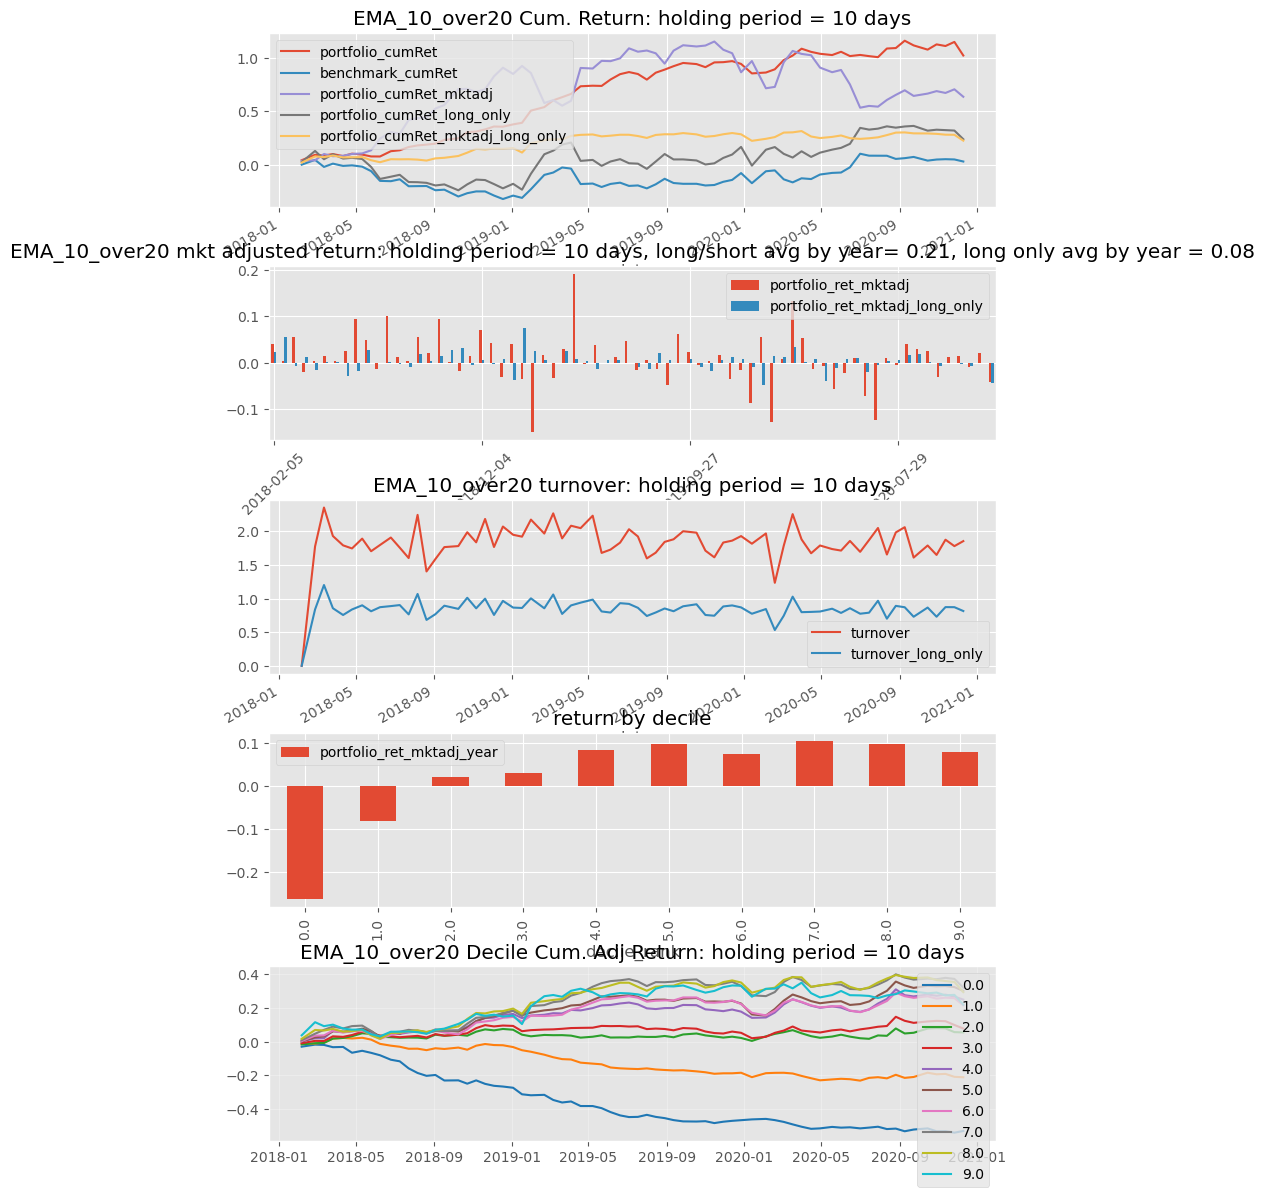

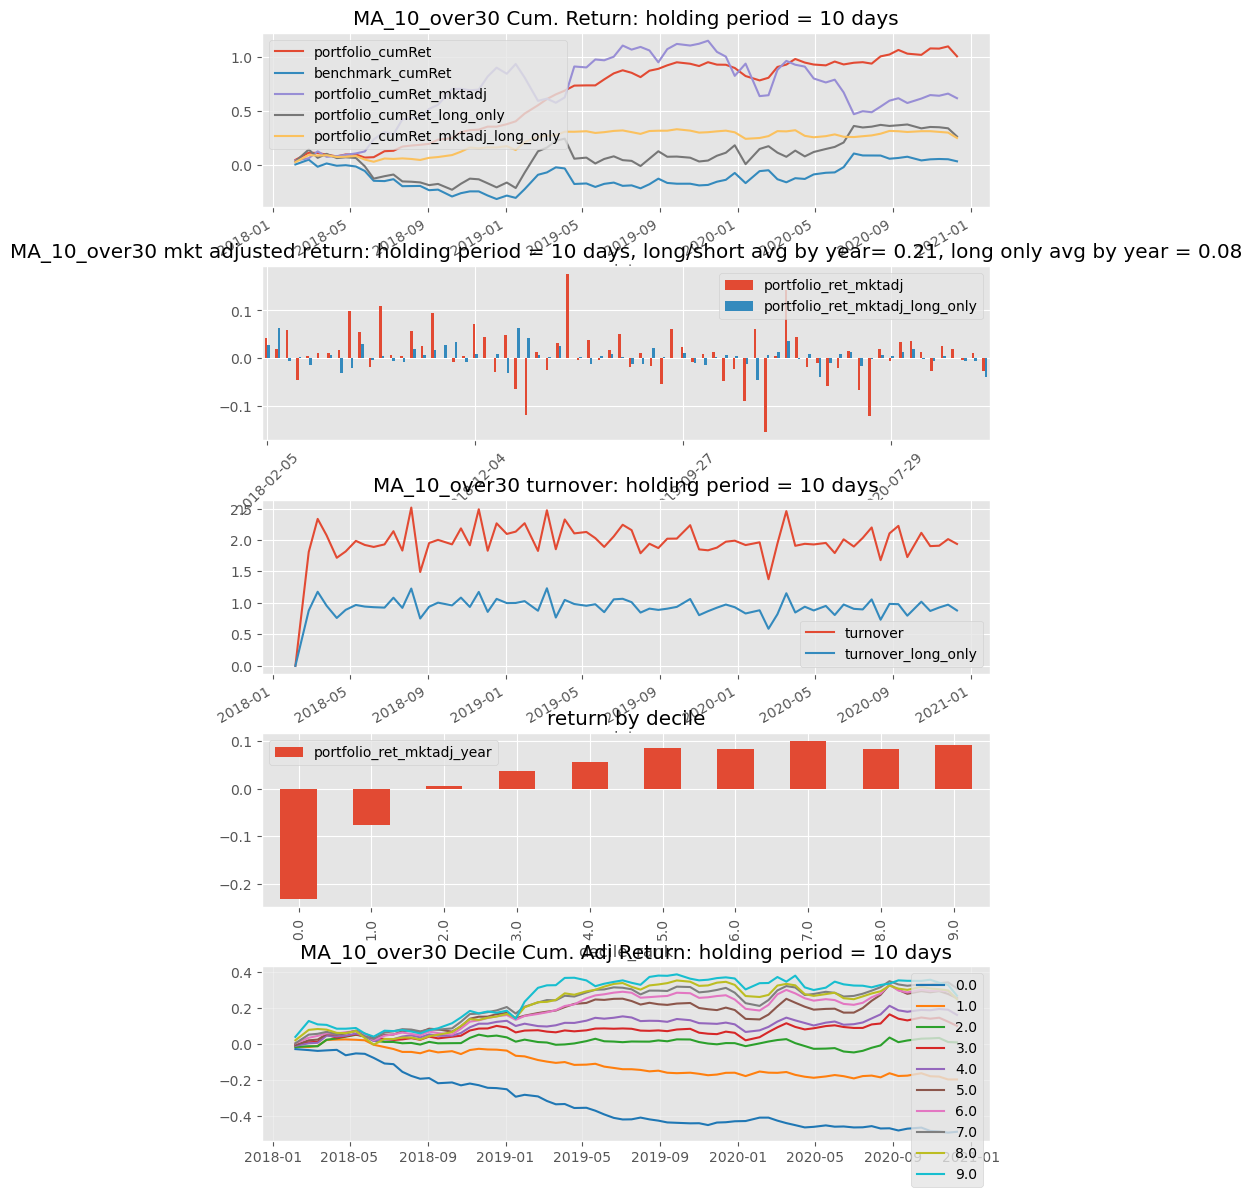

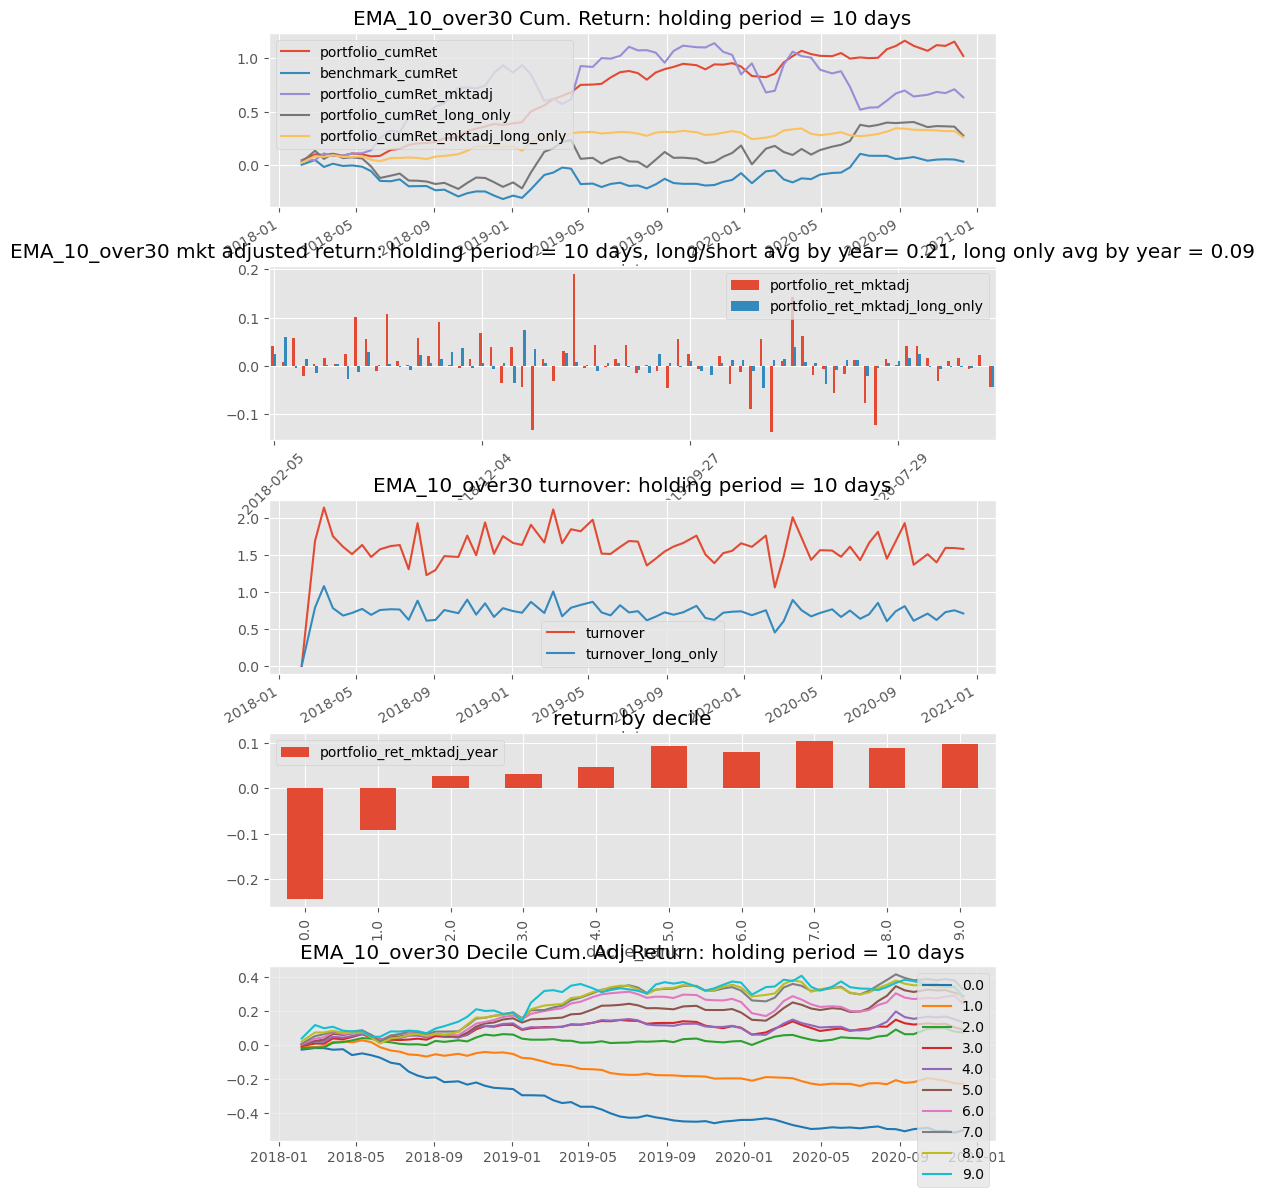

In [70]:
for col in factorCols:
    score = priceData[['date', 'ticker', col]].dropna(subset = [col])
    score[col] = score[col]*(-1)
    portfolioOutput, portfolioStats, portfolioOutput_long, portfolioStats_long, decileOutput, decileStats = bt.runBacktest(backtester_hold10, params, score, col)
    

## mom 003: adj return relative change
####  adj return against it's rolling N day mean
####  adj return = rolling n day return - beta* rolling n day benchmark return 

In [94]:
from alphas.mom.adj_return import calcAdjReturn

In [95]:
data = calcAdjReturn(datetime.date(2018,1,1), endDate, 3)

In [111]:
data_5 = calcAdjReturn(datetime.date(2018,1,1), endDate, 5)

In [117]:
data = data.merge(data_5, on =['date', 'ticker'], how = 'left' )

In [118]:
data_10 = calcAdjReturn(datetime.date(2018,1,1), endDate, 10)

In [119]:
data = data.merge(data_10, on =['date', 'ticker'], how = 'left' )

In [150]:
data = data.sort_values(by = ['date', 'ticker'])

In [121]:
data

date  ticker  adj_return_rolling_3d  adj_return_rolling_3d_3dMA  \
0       2018-01-05  000001               0.017030                         NaN   
1       2018-01-05  000002               0.152833                         NaN   
2       2018-01-05  000004              -0.062669                         NaN   
3       2018-01-05  000005               0.039532                         NaN   
4       2018-01-05  000008              -0.044274                         NaN   
...            ...     ...                    ...                         ...   
2421515 2020-12-31  688333              -0.041488                   -0.037567   
2421516 2020-12-31  688366              -0.010150                   -0.040709   
2421517 2020-12-31  688368               0.061044                    0.000981   
2421518 2020-12-31  688369               0.035680                    0.044260   
2421519 2020-12-31  688388              -0.142074                   -0.031626   

         adj_return_rolling_3d_3dchange  adj_return_rolling_5d  \
0                                   NaN                    NaN   
1                                   NaN                    NaN   
2                                   NaN                    NaN   
3                                   NaN                    NaN   
4                                   NaN                    NaN   
...                                 ...                    ...   
2421515                        1.104382              -0.066614   
2421516                        0.249334              -0.068191   
2421517                       62.199145               0.000995   
2421518                        0.806139               0.067222   
2421519                        4.492271               0.010920   

         adj_return_rolling_10d  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN  
...                         ...  
2421515                0.187957  
2421516               -0.103902  
2421517                0.005359  
2421518                0.099303  
2421519                0.262128  

[2421520 rows x 7 columns]

In [161]:
def addRollingMeanAndChange(data, col, window):
#for window in [3, 5, 10]:
    MA_col = col + '_' + str(window)  + 'dMA' 
    change_col = col + '_' + str(window)  + 'dchange' 
    EMA_col = col + '_'  + str(window)  + 'dEMA' 
    
    data[MA_col] = data.groupby([ 'ticker'])[col].transform(lambda x: x.rolling(window, int(np.ceil(window/2))).mean()) 
    data[MA_col] = data.groupby([ 'ticker'])[MA_col].shift(1)
    data[EMA_col] =  data.groupby([ 'ticker'])[col].transform(lambda x: x.ewm(span = window, min_periods = int(np.ceil(window/2)) ).mean())
    data[change_col] =  data[col]/ data[MA_col]
    return data


In [162]:
for col in ['adj_return_rolling_3d','adj_return_rolling_5d', 'adj_return_rolling_10d']:
    data = addRollingMeanAndChange(data, col, 3)
    data = addRollingMeanAndChange(data, col, 5)

In [147]:
factorCols = Filter(data.columns.to_list(), ['change'])

In [148]:
factorCols

['adj_return_rolling_3d_3dchange',
 'adj_return_rolling_3d_5dchange',
 'adj_return_rolling_5d_3dchange',
 'adj_return_rolling_5d_5dchange',
 'adj_return_rolling_10d_3dchange',
 'adj_return_rolling_10d_5dchange']

### Observations:
#### no significant patterns in relative change signal

In [165]:
factorCols = Filter(data.columns.to_list(), ['EMA'])

In [166]:
factorCols

['adj_return_rolling_3d_3dEMA',
 'adj_return_rolling_3d_5dEMA',
 'adj_return_rolling_5d_3dEMA',
 'adj_return_rolling_5d_5dEMA',
 'adj_return_rolling_10d_3dEMA',
 'adj_return_rolling_10d_5dEMA']

### Observations:
#### for EMA of adjust returns, both the top and bottom deciles get negative return, while others are monotonically increasing, which means reversion for the largest score, can do long only on the reverse signal

In [171]:
params = {
    'holdingPeriod':3,
    'signal_univ':'zz9999', #'zz9999'
    'bmk':'000905',
    'neutralize_method': None,
    'weight_method': 'zscore', #'equal'
    'decile_number': 10,
    'top_decile':0,
    'bottom_decile':9   
    
}

C:\Users\bella\OneDrive\Desktop\projects\QiShi\code\backtester\backtest.py:389: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=2.0)
C:\Users\bella\OneDrive\Desktop\projects\QiShi\code\backtester\backtest.py:389: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=2.0)
C:\Users\bella\OneDrive\Desktop\projects\QiShi\code\backtester\backtest.py:389: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=2.0)
C:\Users\bella\OneDrive\Desktop\projects\QiShi\code\backtester\backtest.py:389: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=2.0)
C:\Users\bella\OneDrive\Desktop\projects\QiShi\code\backtester\backtest.py:389: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=2.0)
C:\Users\bella\OneDrive\Desktop\projects\QiShi\code\backtester\backtest.py:389: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=2.0)


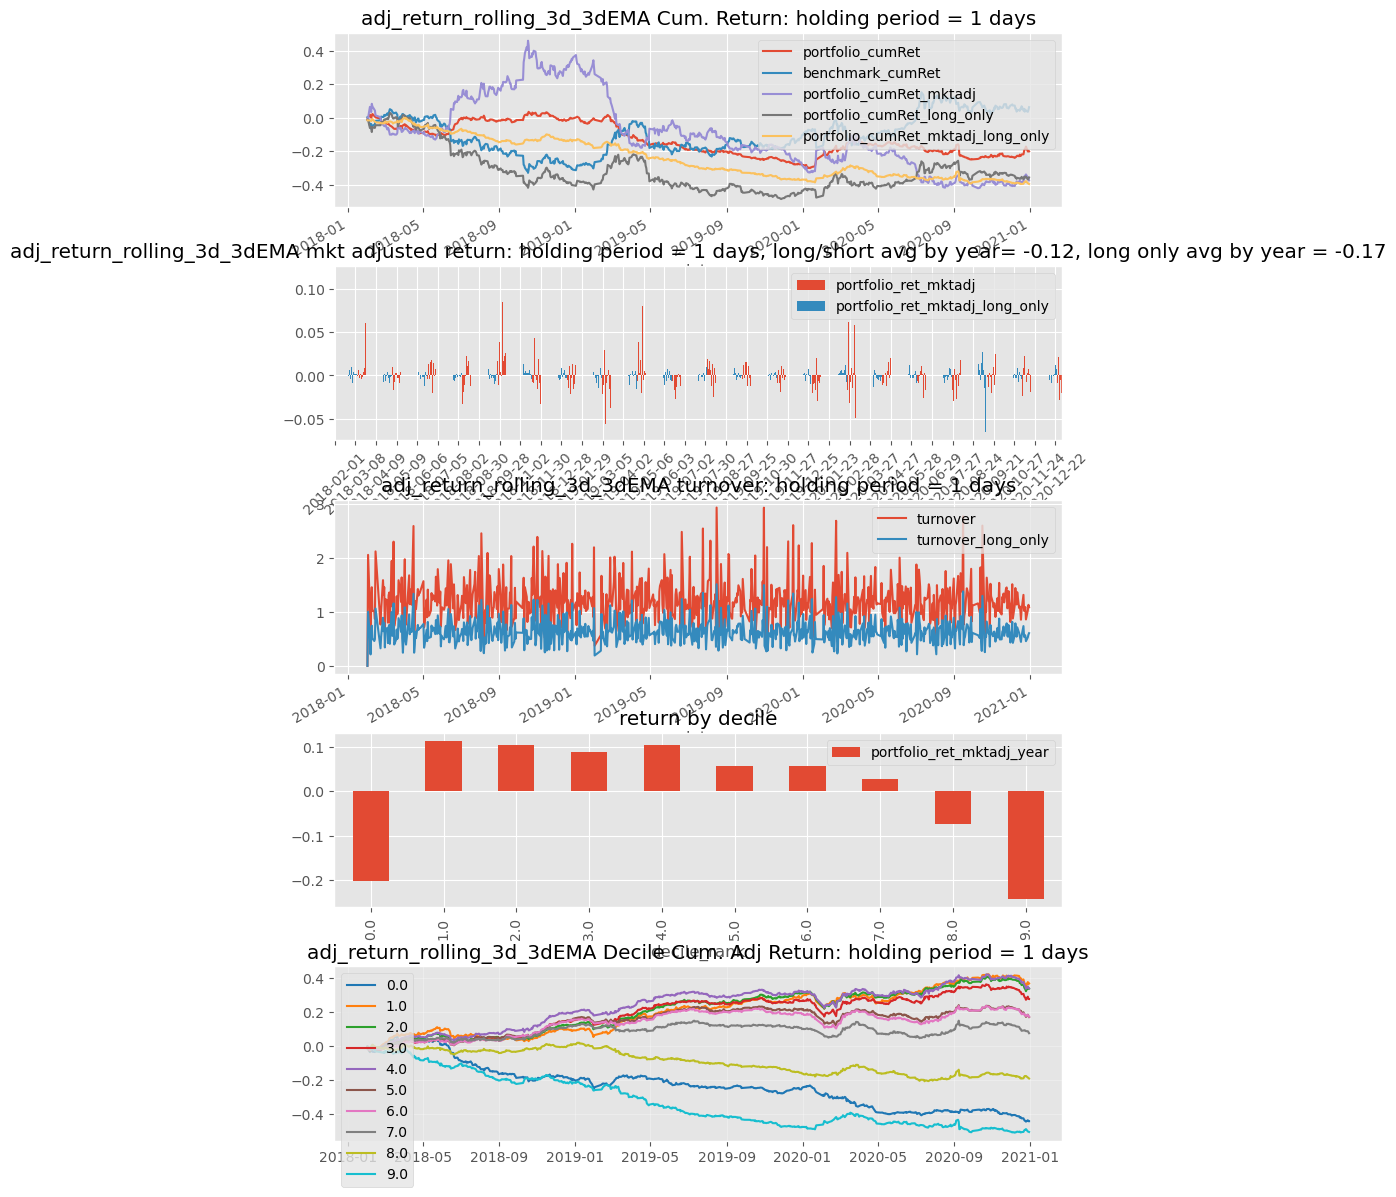

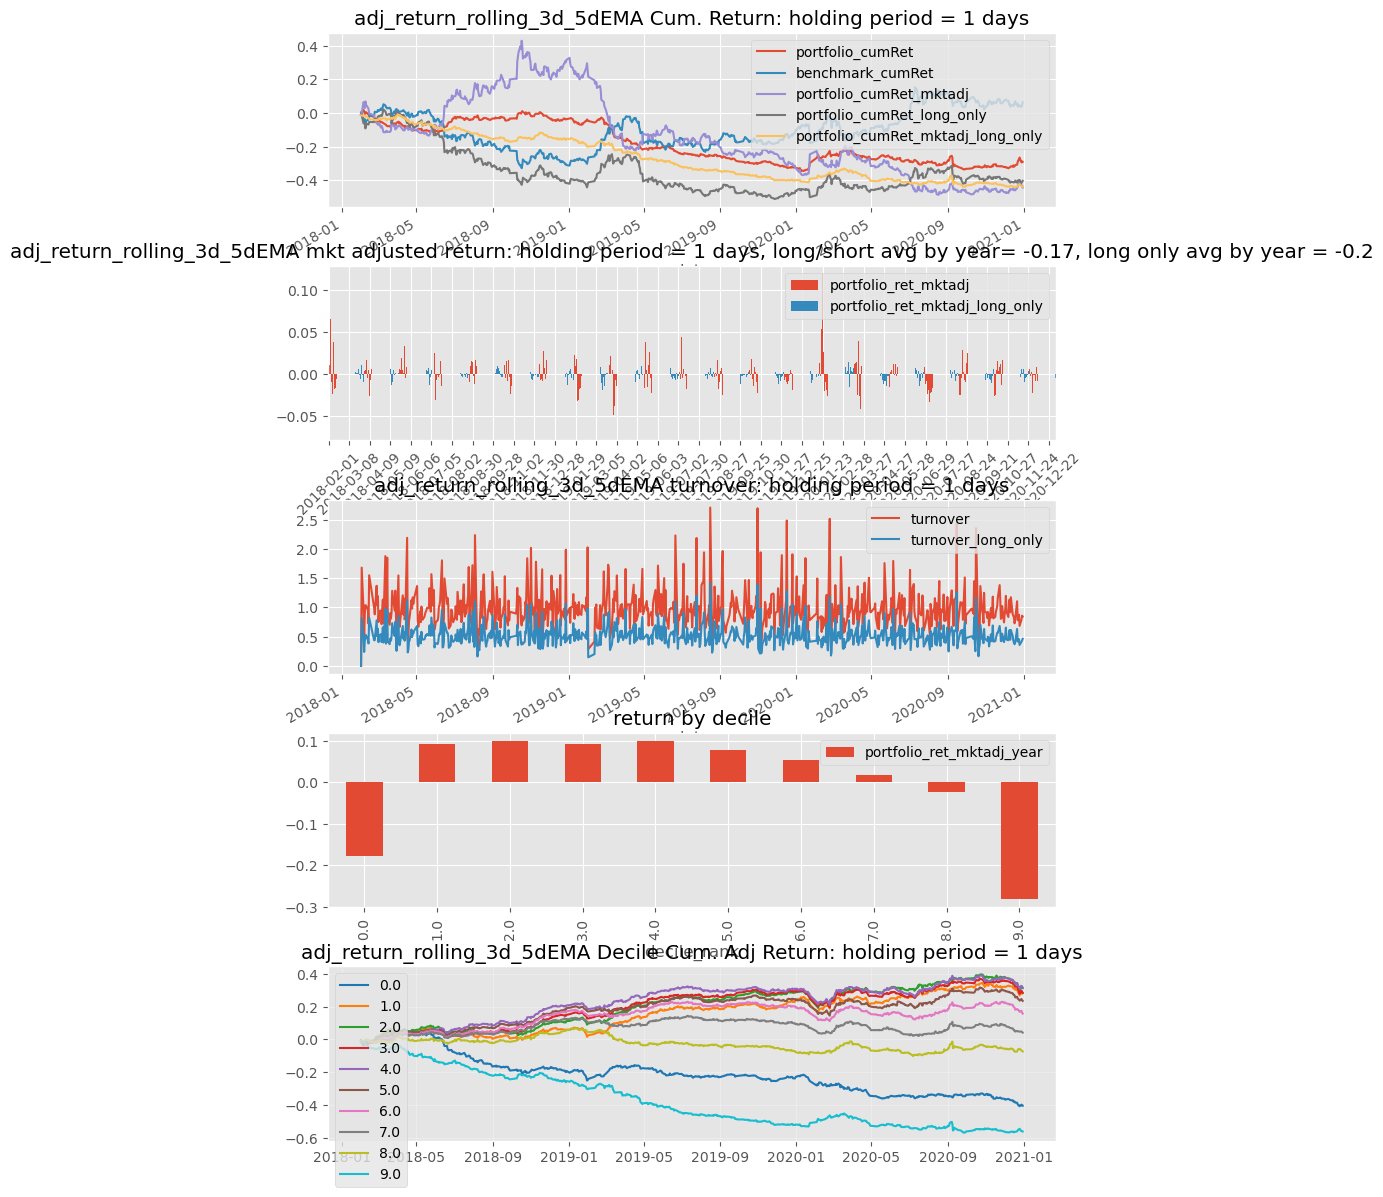

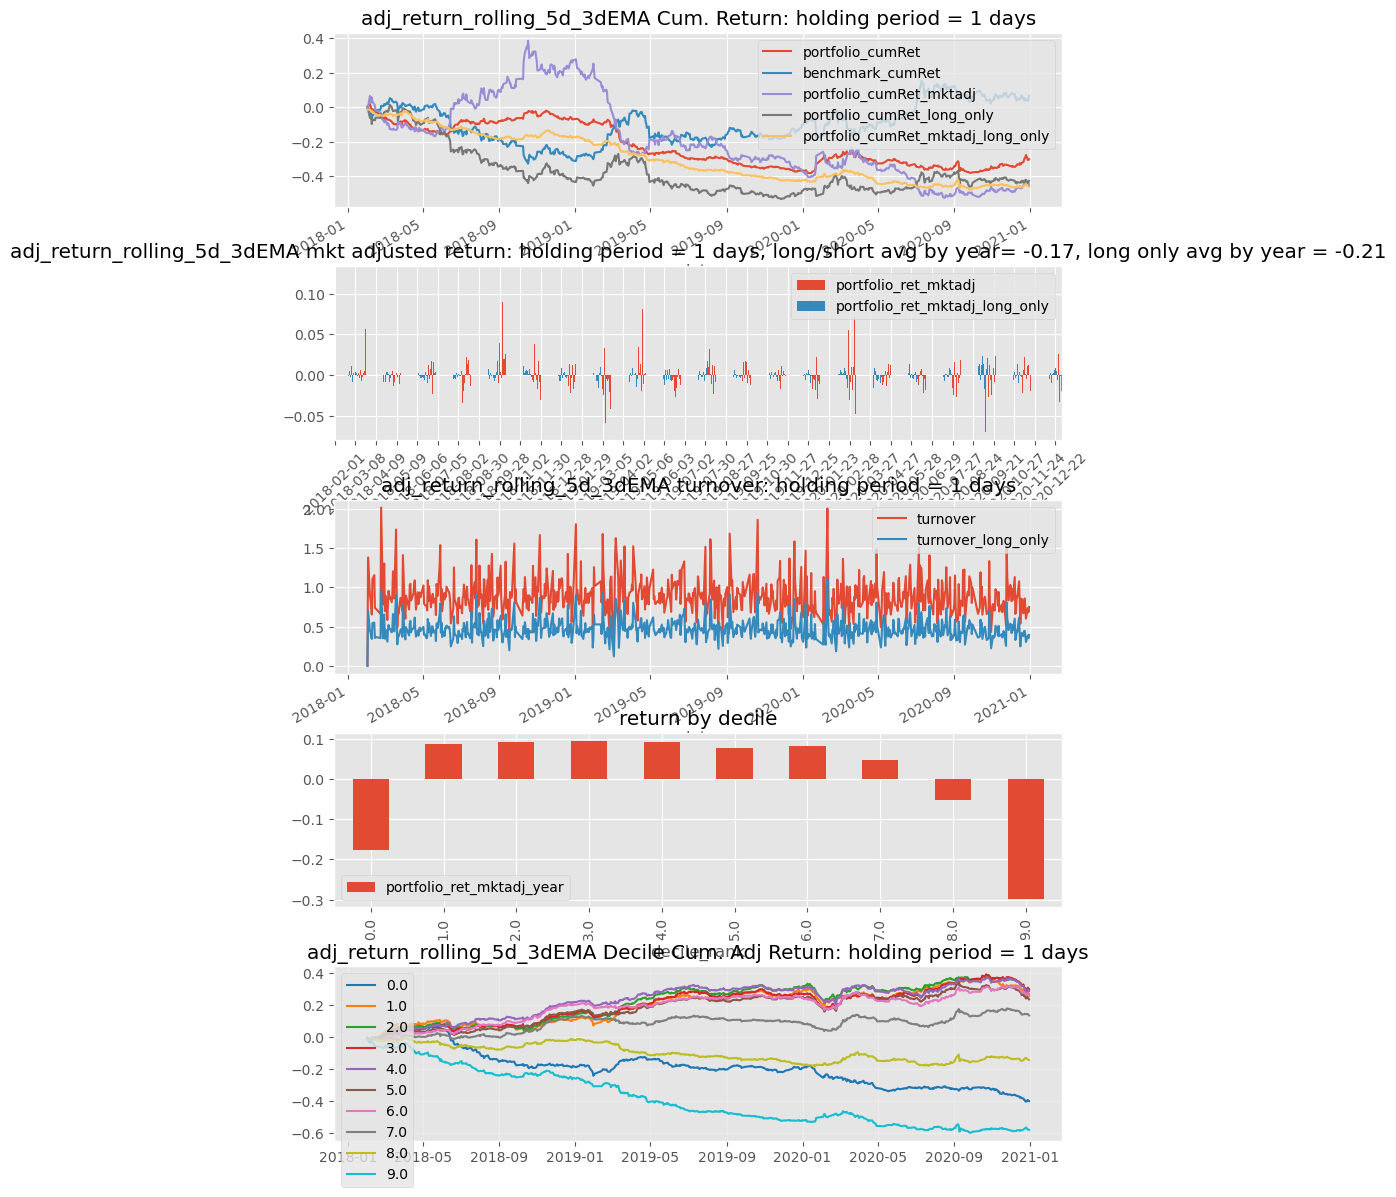

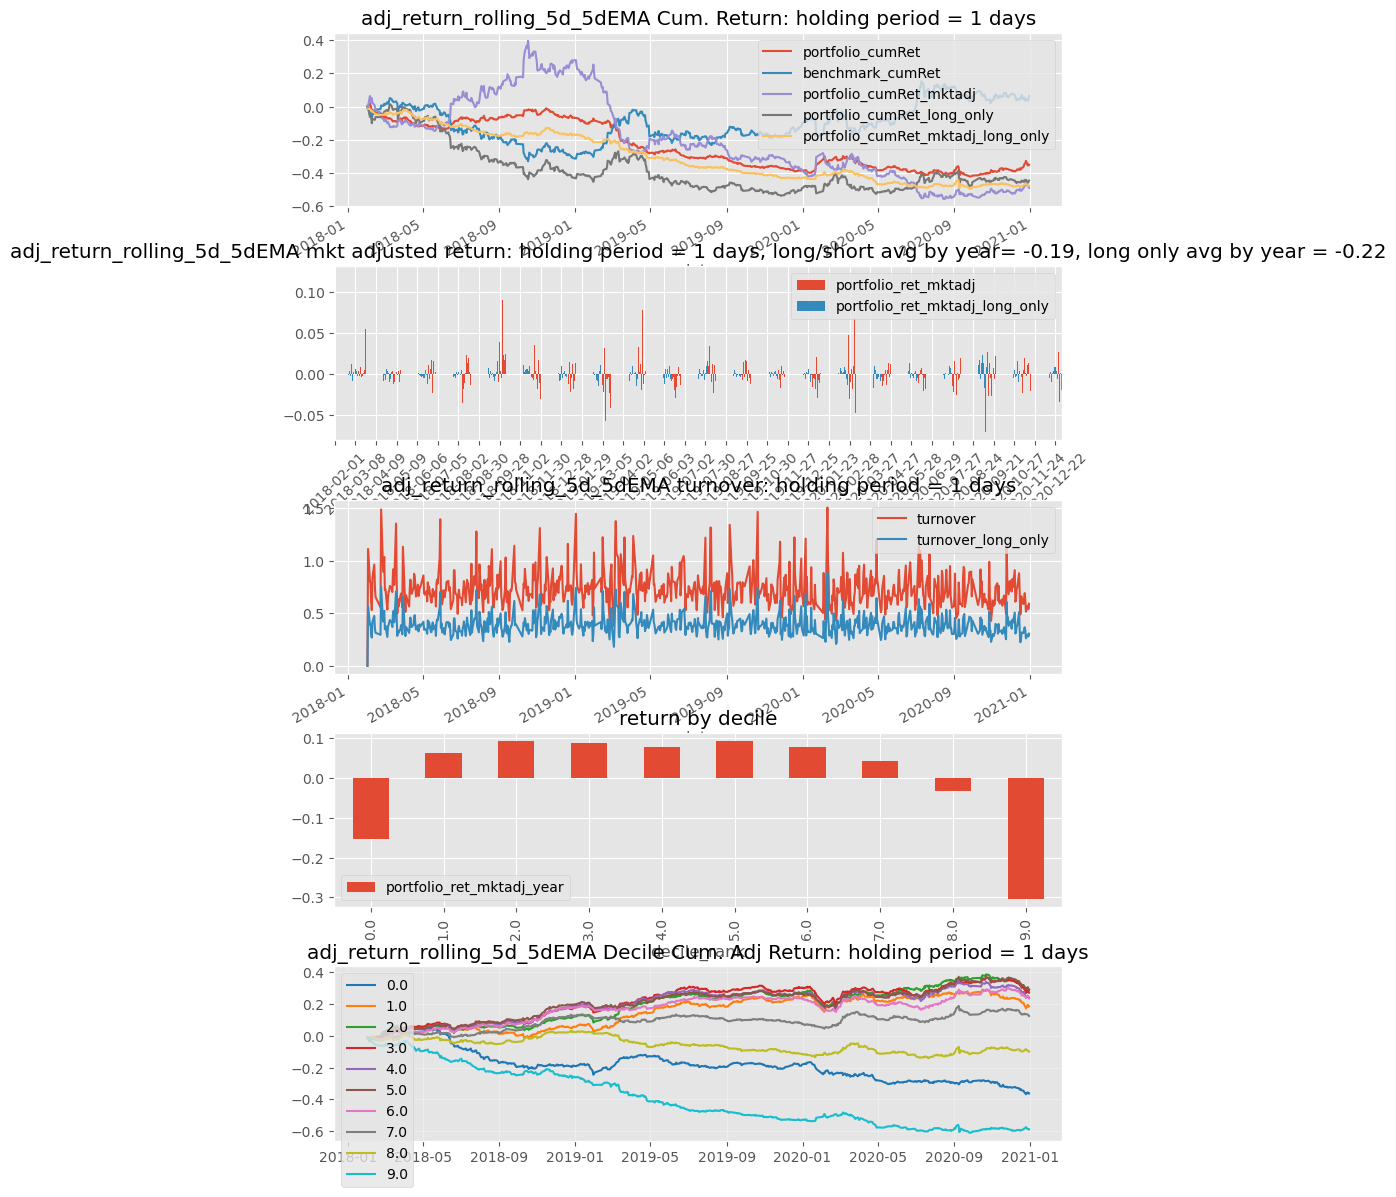

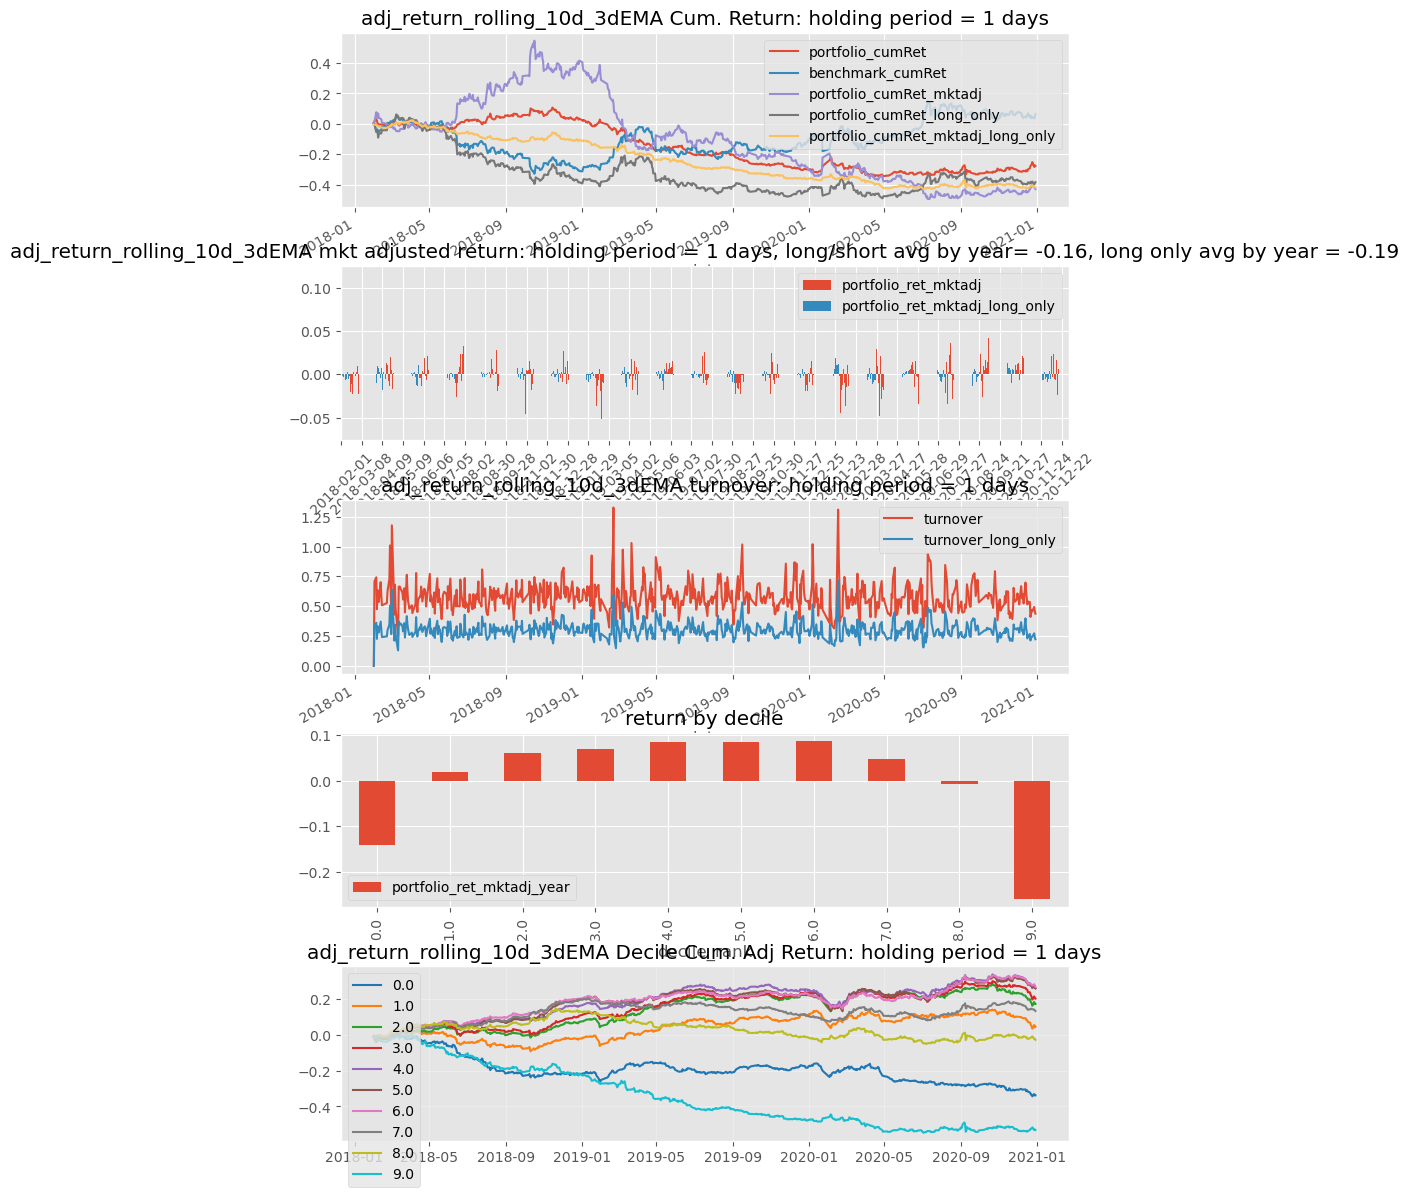

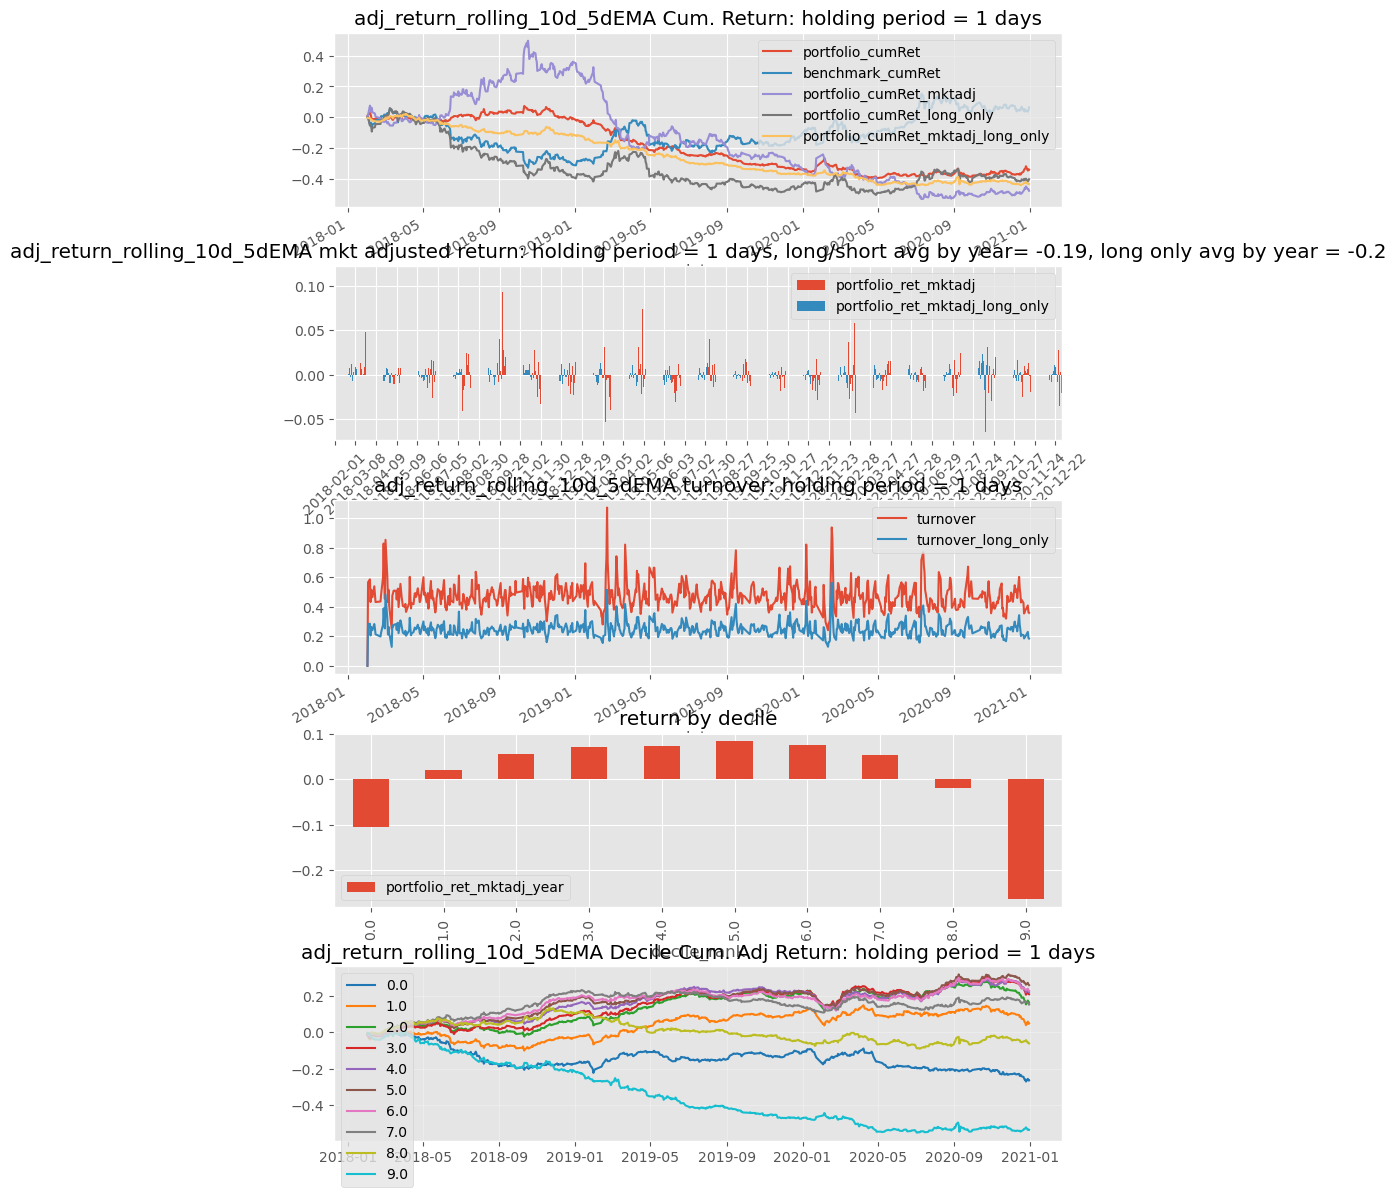

In [172]:

for col in  factorCols:
    score = data[['date', 'ticker', col]].dropna(subset = [col])
    portfolioOutput, portfolioStats, portfolioOutput_long, portfolioStats_long, decileOutput, decileStats = bt.runBacktest(backtester_hold3, params, score, col )


In [114]:
portfolioStats

portfolioIR  portfolioIC  portfolioIC_sig_ratio  turnover  maxDrawDown  \
0    -0.579925    -0.034316               0.859574  2.882146     0.602645   

    corrBmk    decay1    decay3   decay5   decay10   decay20  
0 -0.176373 -0.034316  0.003041 -0.01304  0.009618 -0.001789

In [108]:
data =  addRollingMeanAndChange(data, 'adj_return_rolling_3d', 3)

date  ticker  adj_return_rolling_3d  adj_return_rolling_3d_3dMA  \
2263    2018-01-05  000001               0.017030                         NaN   
2004    2018-01-05  000002               0.152833                         NaN   
2005    2018-01-05  000004              -0.062669                         NaN   
2006    2018-01-05  000005               0.039532                         NaN   
2007    2018-01-05  000008              -0.044274                         NaN   
...            ...     ...                    ...                         ...   
2419136 2020-12-31  688333              -0.041488                   -0.037567   
2419137 2020-12-31  688366              -0.010150                   -0.040709   
2418833 2020-12-31  688368               0.061044                    0.000981   
2420318 2020-12-31  688369               0.035680                    0.044260   
2421519 2020-12-31  688388              -0.142074                   -0.031626   

         adj_return_rolling_3d_3dchange  
2263                                NaN  
2004                                NaN  
2005                                NaN  
2006                                NaN  
2007                                NaN  
...                                 ...  
2419136                        1.104382  
2419137                        0.249334  
2418833                       62.199145  
2420318                        0.806139  
2421519                        4.492271  

[2421520 rows x 5 columns]

In [ ]:
for col in factorCols:
    score = data[['date', 'ticker', col]].dropna(subset = [col])
    portfolioOutput, portfolioStats, portfolioOutput_long, portfolioStats_long, decileOutput, decileStats = bt.runBacktest(backtester_hold1, params, score, col)


## mom 004: Bollinger z score
#### Bollinger z score, (Price - MA) / sigma

In [100]:
for window in [3, 5, 10, 15, 20]:
    MA_col = str(window)  + 'dMA' 
    EMA_col = str(window)  + 'dEMA' 
    std_col = str(window)  + 'dstd' 
    zscore_col_ma = str(window)  + 'dzscore_ma' 
    zscore_col_ema = str(window)  + 'dzscore_ema' 
    
    priceData[MA_col] = priceData.groupby([ 'ticker'])['close'].transform(lambda x: x.rolling(window, int(np.ceil(window/2))).mean()) 
    priceData[std_col] = priceData.groupby([ 'ticker'])['close'].transform(lambda x: x.rolling(window, int(np.ceil(window/2))).std()) 
    priceData[EMA_col] =  priceData.groupby([ 'ticker'])['close'].transform(lambda x: x.ewm(span = window, min_periods = int(np.ceil(window/2)) ).mean())
    
    priceData[zscore_col_ma] = np.where(priceData[std_col]!=np.nan, (priceData['close'] - priceData[MA_col])/ priceData[std_col], np.nan)
    priceData[zscore_col_ema] = np.where(priceData[std_col]!=np.nan, (priceData['close'] - priceData[EMA_col])/ priceData[std_col], np.nan)
    
    priceData.loc[priceData[std_col] == 0, zscore_col_ma] = 0
    priceData.loc[priceData[std_col] == 0, zscore_col_ema] = 0

  

In [74]:
zCols = Filter(priceData.columns.to_list(), ['zscore'])

In [75]:
zCols

['5dzscore_ma',
 '5dzscore_ema',
 '10dzscore_ma',
 '10dzscore_ema',
 '15dzscore_ma',
 '15dzscore_ema',
 '20dzscore_ma',
 '20dzscore_ema']

In [ ]:
for col in zCols:
    priceData[col+ '_pctchange'] = priceData.groupby([ 'ticker'])[col].transform(lambda x: x.rolling(window, int(np.ceil(window/2))).mean()) 

## observation:
#### z score itself doesn't have a significant pattern, with top, bottom performance lower but middle groups are higher
#### which means if z score is around the mean, there will be higher return, we can change z score to a "vol" measure, the lower the vol, the higher the return

In [154]:
factorCols = Filter(priceData.columns.to_list(), ['std'])

In [155]:
factorCols

['5dstd', '10dstd', '15dstd', '20dstd', '3dstd']

In [156]:
params = {
    'holdingPeriod':5,
    'signal_univ':'zz9999', #'zz9999'
    'bmk':'000905',
    'neutralize_method': None,
    'weight_method': 'zscore', #'equal'
    'decile_number': 10,
    'top_decile':0,
    'bottom_decile':9   
    
}

C:\Users\bella\OneDrive\Desktop\projects\QiShi\code\backtester\backtest.py:389: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=2.0)
C:\Users\bella\OneDrive\Desktop\projects\QiShi\code\backtester\backtest.py:389: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=2.0)
C:\Users\bella\OneDrive\Desktop\projects\QiShi\code\backtester\backtest.py:389: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=2.0)
C:\Users\bella\OneDrive\Desktop\projects\QiShi\code\backtester\backtest.py:389: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=2.0)
C:\Users\bella\OneDrive\Desktop\projects\QiShi\code\backtester\backtest.py:389: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=2.0)


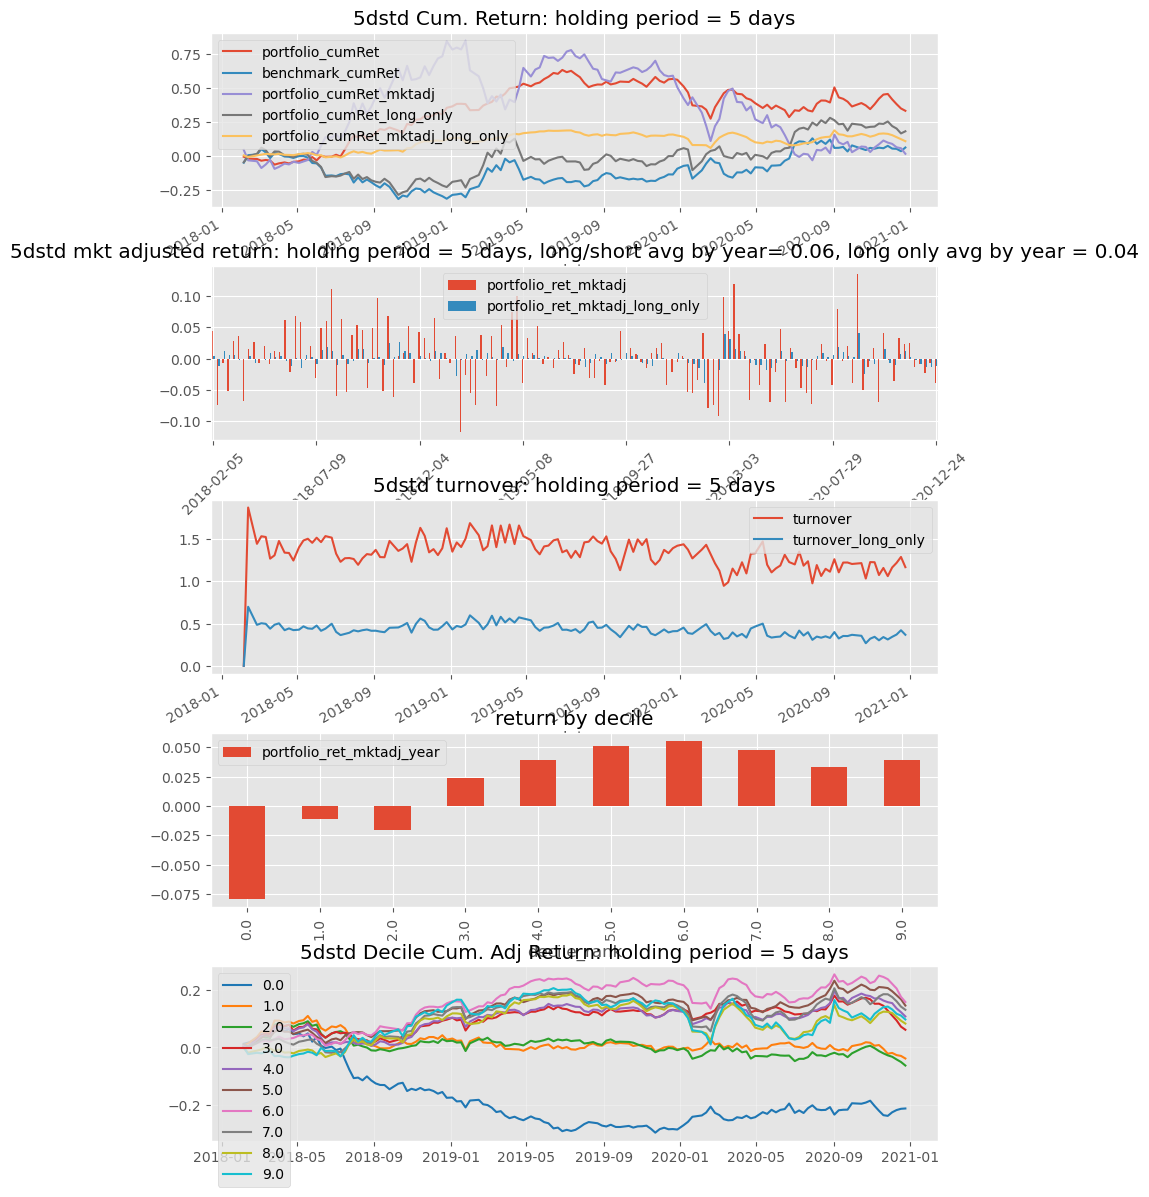

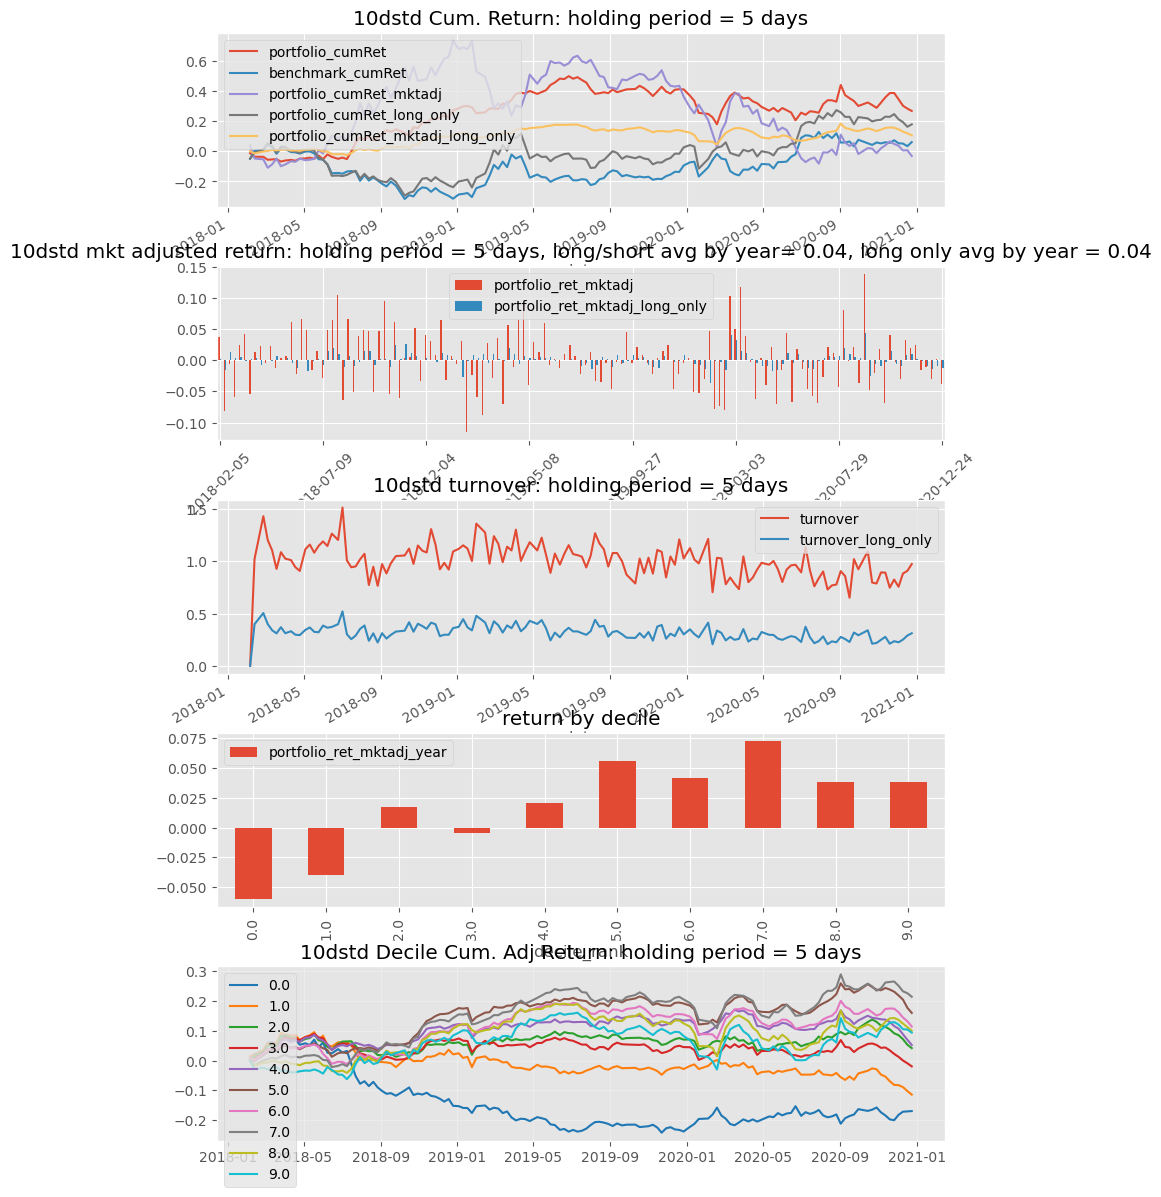

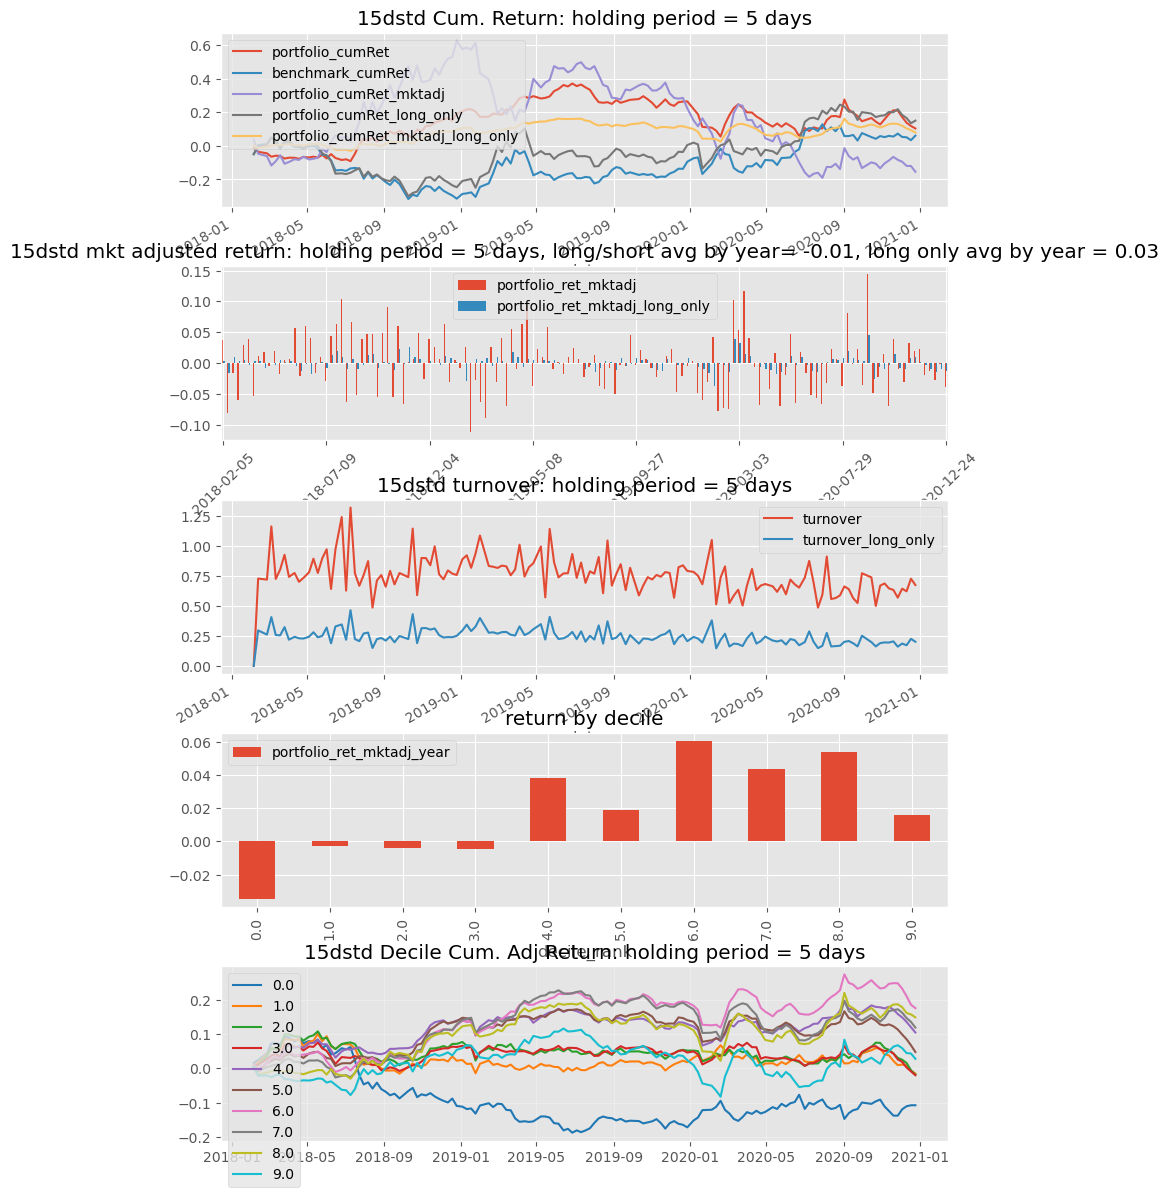

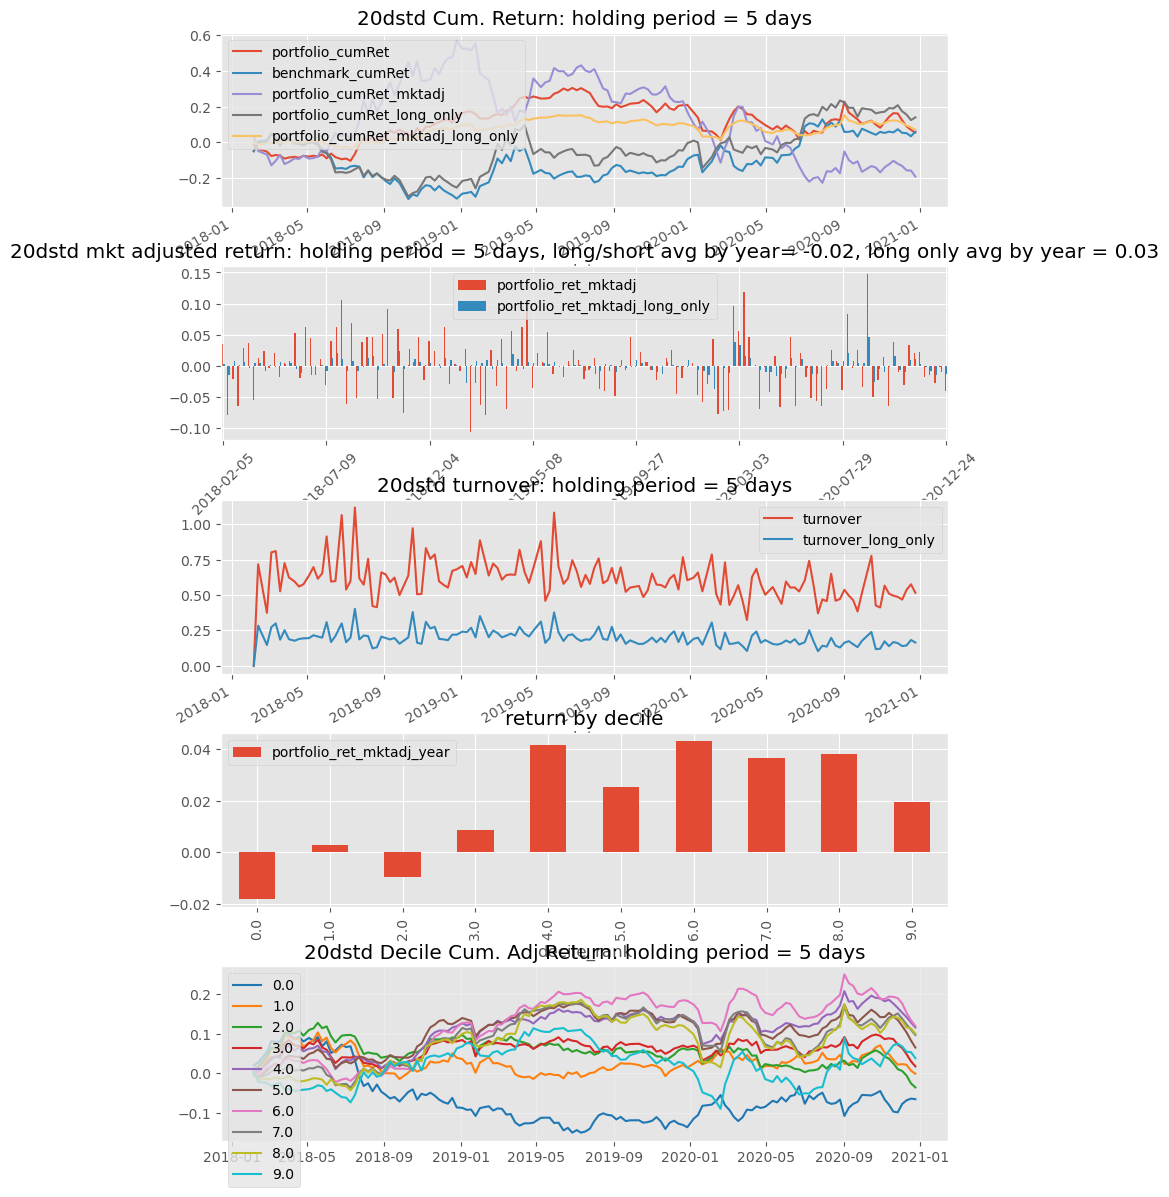

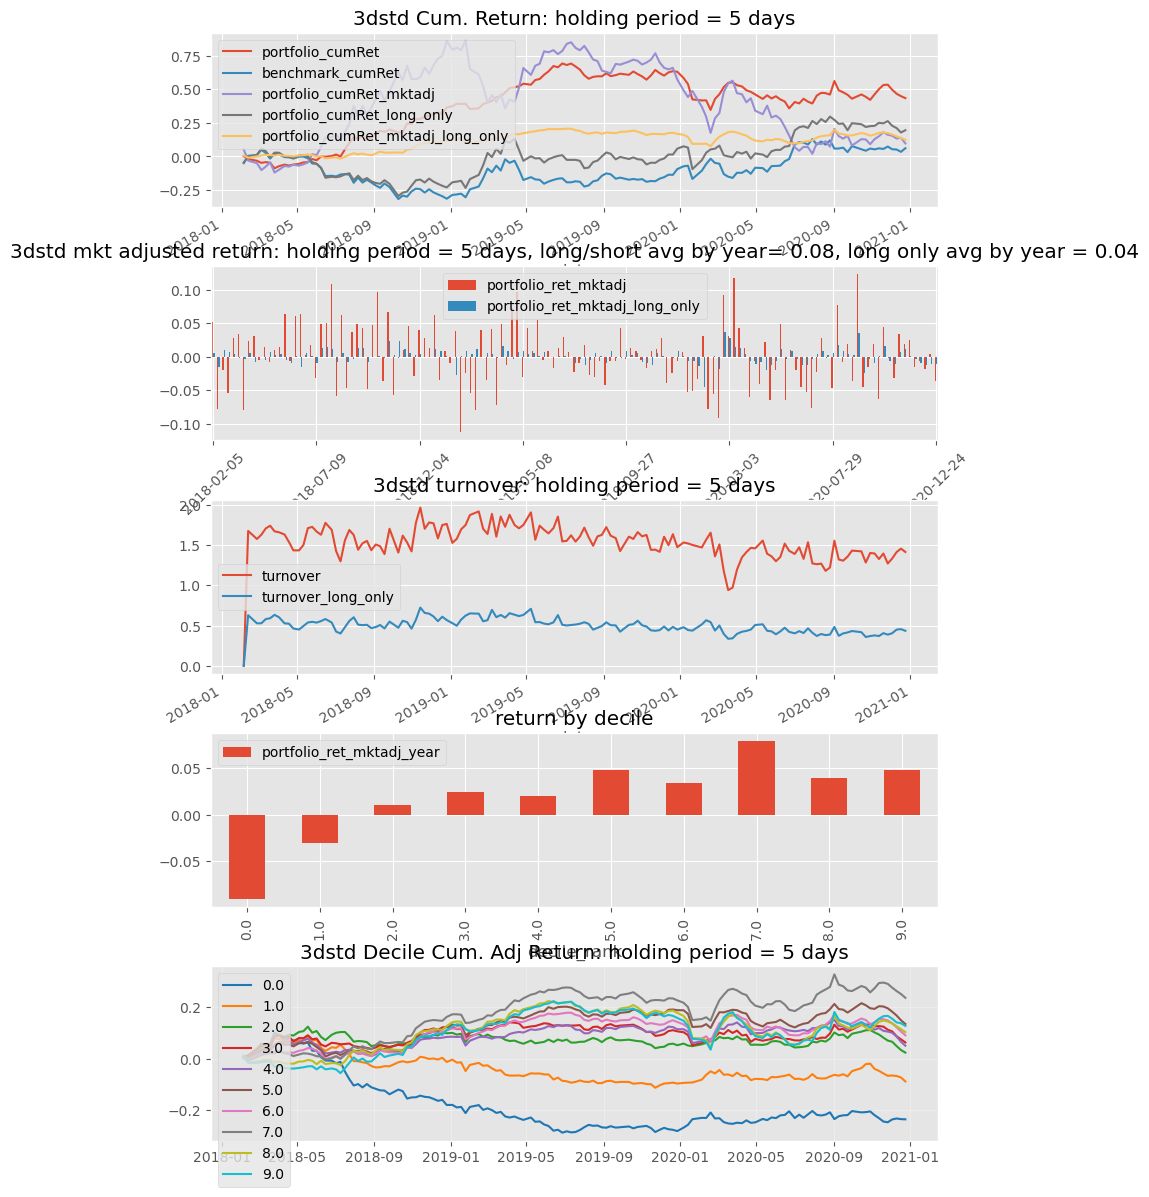

In [157]:
for col in factorCols:
    score = priceData[['date', 'ticker', col]].dropna(subset = [col])
    score[col] = (-1)*score[col]
    portfolioOutput, portfolioStats, portfolioOutput_long, portfolioStats_long, decileOutput, decileStats = bt.runBacktest(backtester_hold5, params, score, col)
